In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

## Load The Data

In [3]:
from google.colab import drive
drive.mount('/drive')
df = pd.read_csv('/drive/My Drive/IF5171 [TUBES] Pembelajaran Mesin DSAI/4. Progress Report/experiments/XGBRegressor/clean_tlkm10y.csv')

Mounted at /drive


In [4]:
df.head()

,Date,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
0,2012-10-16 00:00:00+07:00,1935.714286,1913.571429,1898.571429,18.126539,1,4,10,2012,290,16,42,1970.0
1,2012-10-17 00:00:00+07:00,1940.000000,1919.285714,1901.904762,17.320508,2,4,10,2012,291,17,42,1950.0
2,2012-10-18 00:00:00+07:00,1940.000000,1922.142857,1904.285714,17.320508,3,4,10,2012,292,18,42,1930.0
3,2012-10-19 00:00:00+07:00,1940.000000,1925.714286,1906.666667,17.320508,4,4,10,2012,293,19,42,1930.0
4,2012-10-22 00:00:00+07:00,1934.285714,1926.428571,1908.095238,19.880596,0,4,10,2012,296,22,43,1910.0


In [5]:
df2 = df.set_index('Date')
df2.index = pd.to_datetime(df2.index)

In [6]:
df2.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,
2012-10-16 00:00:00+07:00,1935.714286,1913.571429,1898.571429,18.126539,1,4,10,2012,290,16,42,1970.0
2012-10-17 00:00:00+07:00,1940.000000,1919.285714,1901.904762,17.320508,2,4,10,2012,291,17,42,1950.0
2012-10-18 00:00:00+07:00,1940.000000,1922.142857,1904.285714,17.320508,3,4,10,2012,292,18,42,1930.0
2012-10-19 00:00:00+07:00,1940.000000,1925.714286,1906.666667,17.320508,4,4,10,2012,293,19,42,1930.0
2012-10-22 00:00:00+07:00,1934.285714,1926.428571,1908.095238,19.880596,0,4,10,2012,296,22,43,1910.0


In [7]:
df2.dtypes

7 DAYS MA         float64
14 DAYS MA        float64
21 DAYS MA        float64
7 DAYS STD DEV    float64
dayofweek           int64
quarter             int64
month               int64
year                int64
dayofyear           int64
dayofmonth          int64
weekofyear          int64
Close             float64
dtype: object

In [8]:
train_len = int(len(df2)*.8)
train_dataset = df2[:train_len]
test_dataset = df2[train_len:len(df2)]

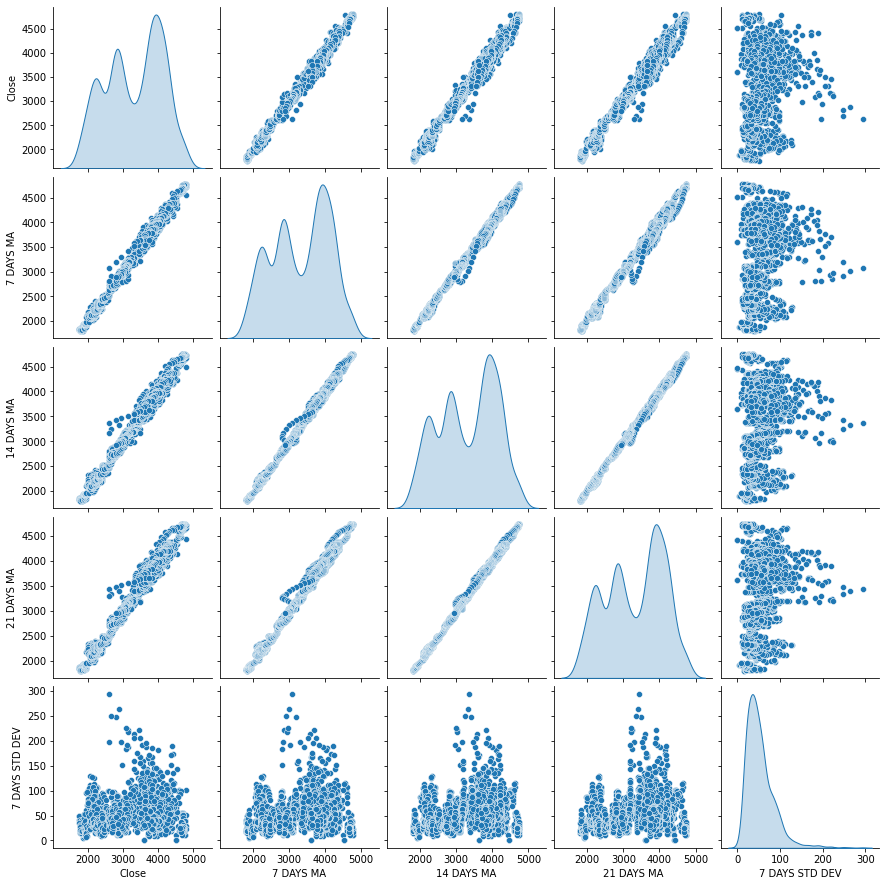

In [15]:
sns.pairplot(train_dataset[['Close', '7 DAYS MA', '14 DAYS MA', '21 DAYS MA', '7 DAYS STD DEV']], diag_kind='kde')

In [21]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

In [22]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
7 DAYS MA,3319.408391,792.736897
14 DAYS MA,3317.612152,793.234627
21 DAYS MA,3315.678717,794.086167
7 DAYS STD DEV,53.125332,33.350980
dayofweek,1.990854,1.411665
quarter,2.491362,1.121009
month,6.462398,3.456698
year,2016.283537,2.292955
dayofyear,181.271850,105.511680
dayofmonth,15.726118,8.745843


In [23]:
type(train_features)

pandas.core.frame.DataFrame

## Modeling with XGBRegressor

### Grid Search

In [26]:
# ================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number 
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================
regressor=xgb.XGBRegressor(eval_metric='rmse')

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [3, 4, 5],
              "n_estimators": [500, 600, 700, 1000],
              "learning_rate": [0.01, 0.015],
              "base_score": [0.5],
              "booster": ["gbtree"],
              "early_stopping_rounds": [50]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(train_features, train_labels)

print("The best hyperparameters are ",search.best_params_)

[07:55:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:55:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:55:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:55:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:55:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:55:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:55:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:55:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

### Compile and fit model using best params resulted from grid search

In [27]:
regressor=xgb.XGBRegressor(learning_rate=0.01,
                           n_estimators=1000,
                           max_depth=3,
                           base_score=0.5,
                           booster='gbtree',
                           early_stopping_rounds=50)

regressor.fit(train_features, train_labels)

[08:01:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

### Prediction

In [28]:
predictions = regressor.predict(test_features)
predictions[:5]

array([2850.9973, 2819.853 , 2819.853 , 2806.1   , 2803.1565],
      dtype=float32)

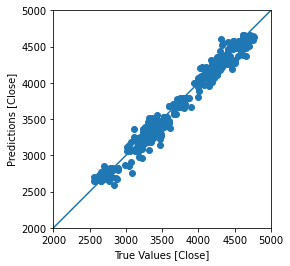

In [34]:
# Predictions
a = plt.axes(aspect='equal')
plt.scatter(test_labels, predictions)
plt.xlabel('True Values [Close]')
plt.ylabel('Predictions [Close]')
lims = [2000, 5000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

### Evaluation

In [29]:
# Evaluation helpers
from sklearn.metrics import mean_squared_error

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [32]:
rmse_score = np.sqrt(mean_squared_error(test_labels,predictions))
mape_score = mape(test_labels,predictions)
print(f"RMSE: {rmse_score}; MAPE: {mape_score}%")

RMSE: 89.68850009311706; MAPE: 1.847264066063981%


### Save the model

In [38]:
# Save model
regressor.save_model('/drive/My Drive/IF5171 [TUBES] Pembelajaran Mesin DSAI/4. Progress Report/experiments/XGBRegressor/models/best_xgbreg_tlkm.json')

In [40]:
# model2 = xgb.XGBRegressor()
# model2.load_model("best_xgbreg_tlkm.json")
# preds = model2.predict(test_features)
# preds[:5]